# Zrozumienie problemu

## Nasze zadanie


Naszym zadaniem jest zbudowanie modelu regresyjnego który wytrenujemy za pomocą danych zawartych w pliku 'train.csv'. Zestaw danych zawiera 1460 próbek. Każda próbka składa się z 82 cech. Nasz model będzie miał za zadanie z jak największą dokładnością przewidzieć ceny nieruchomości z pliku 'test.csv'. Ze względu na wiele cech, będziemy musieli zredukować ich wymiary, poprzez wyodrebnienie najbardziej wartościowych cech, aby uniknąć przetrenowania modelu. Aby to zrobić, wpierw musimy dobrze zrozumieć problem i przeanalizować dane.

### Ames, Iowa

Ames w stanie Iowa to miasto założone w 1864 liczące 66,498 mieszkańców. Właśnie na podstawie domów z tego miasta został utworzony zestaw danych. Wypiszmy sobie pare informacji o Ames: 


Ames w stanie Iowa to miasto założone w 1864 liczące 66,498 mieszkańców. Właśnie na podstawie domów z tego miasta został utworzony zestaw danych. Wypiszmy sobie pare informacji o Ames: <br><br>
<b>Rok założenia</b>: 1864 <br>
<b>Kraj</b>: Stany zjednoczone <br>
<b>Stan</b>: Iowa <br>
<b>Liczba mieszkańców</b>: 66,498 <br>
<b>Powierzchnia</b>:  62,86 km²<br>
<b>Klimat</b>: Wilgotny <br><br>

Warto wspomnieć że w Ames stacjonuje <b>Iowa State University</b>, z wiązku z tym około połowa mieszkanćów to studenci!

### Mapa Ames

![Ames](ames_map.png)

# Eksploracja danych

In [1]:
#Importujemy niezbędne moduły
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from scipy.stats import skew
from scipy.special import boxcox1p

In [2]:
#wczytujemy dane
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
idd = data_test.Id
data_train = data_train.drop("Id", axis=1)
data_test = data_test.drop("Id", axis=1)
print(data_train.shape)
print(data_test.shape)

(1460, 80)
(1459, 79)


## Poznajmy nasze dane 

Pełen opis danych znajduję się w pliku <i>description.txt</i>, więc nie będziemy umieszczać go tutaj. Przyjrzyjy się jednak jak dane się zachowują względem zmiennej objaśnianej <b><i>SalePrice</i></b>

In [3]:
print(data_train.SalePrice.describe())
print(data_train.SalePrice.median())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
163000.0


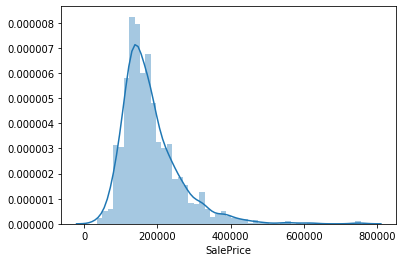

In [4]:
sns.distplot(data_train.SalePrice)

In [5]:
data_train.SalePrice = np.log1p(data_train.SalePrice)

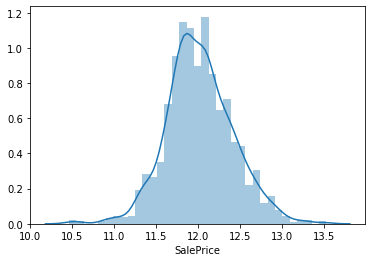

In [6]:
sns.distplot(data_train.SalePrice)

No handles with labels found to put in legend.


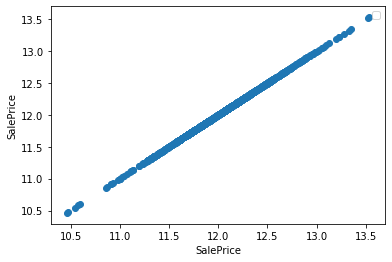

No handles with labels found to put in legend.


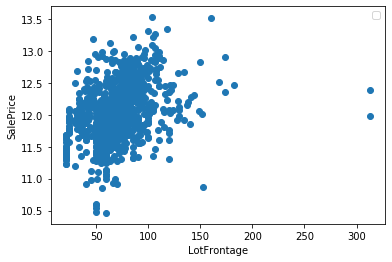

No handles with labels found to put in legend.


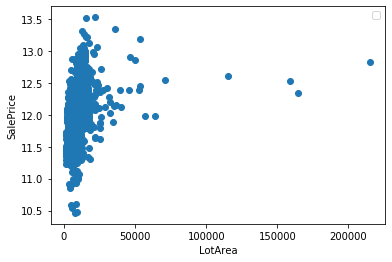

No handles with labels found to put in legend.


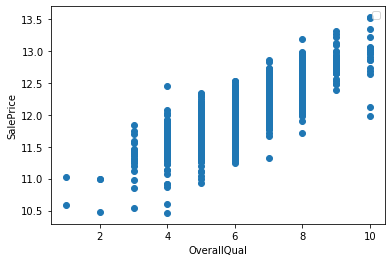

No handles with labels found to put in legend.


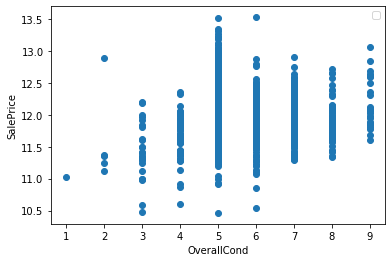

No handles with labels found to put in legend.


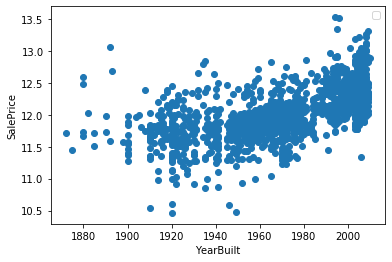

No handles with labels found to put in legend.


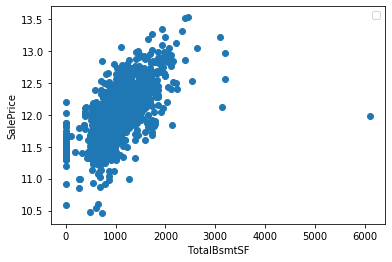

No handles with labels found to put in legend.


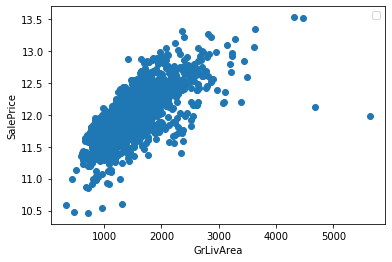

No handles with labels found to put in legend.


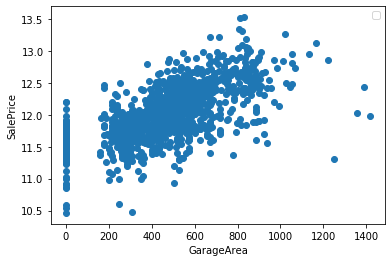

In [7]:
columns= ["SalePrice", "LotFrontage", "LotArea", "OverallQual", "OverallCond", "YearBuilt", "TotalBsmtSF", "GrLivArea", "GarageArea"]
for i in columns:
    plt.scatter(data_train[i], data_train["SalePrice"])
    plt.xlabel(i)
    plt.ylabel("SalePrice")
    plt.legend()
    plt.show()

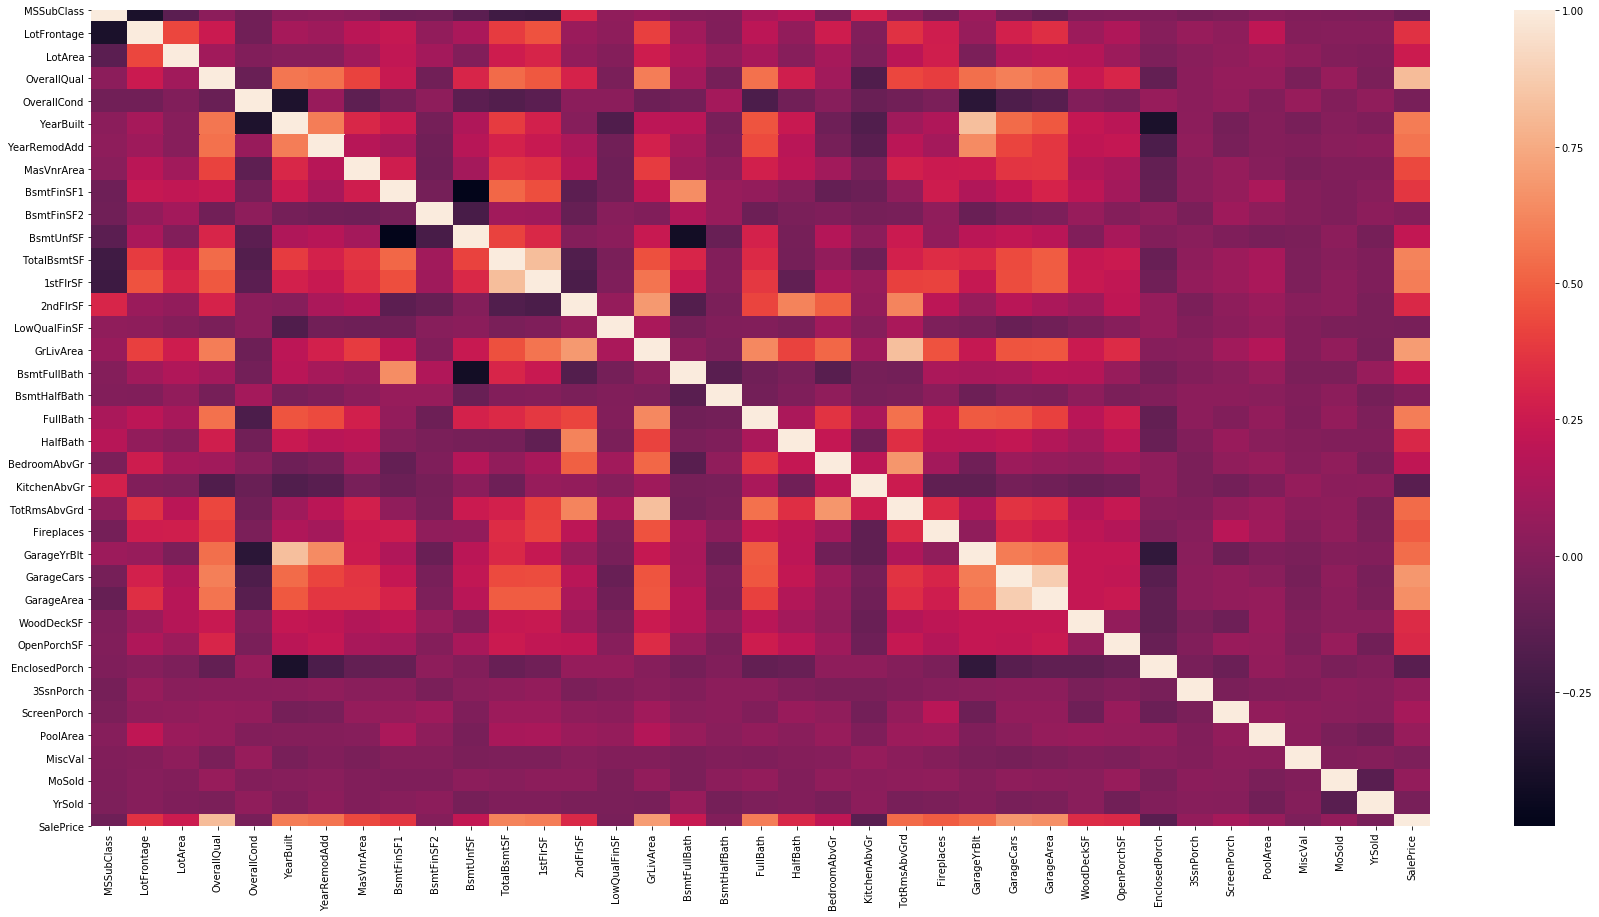

In [8]:
plt.figure(figsize=[30,15])
correlation = data_train.corr()
sns.heatmap(correlation)

c:\users\michal\appdata\local\programs\python\python37-32\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
c:\users\michal\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\michal\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


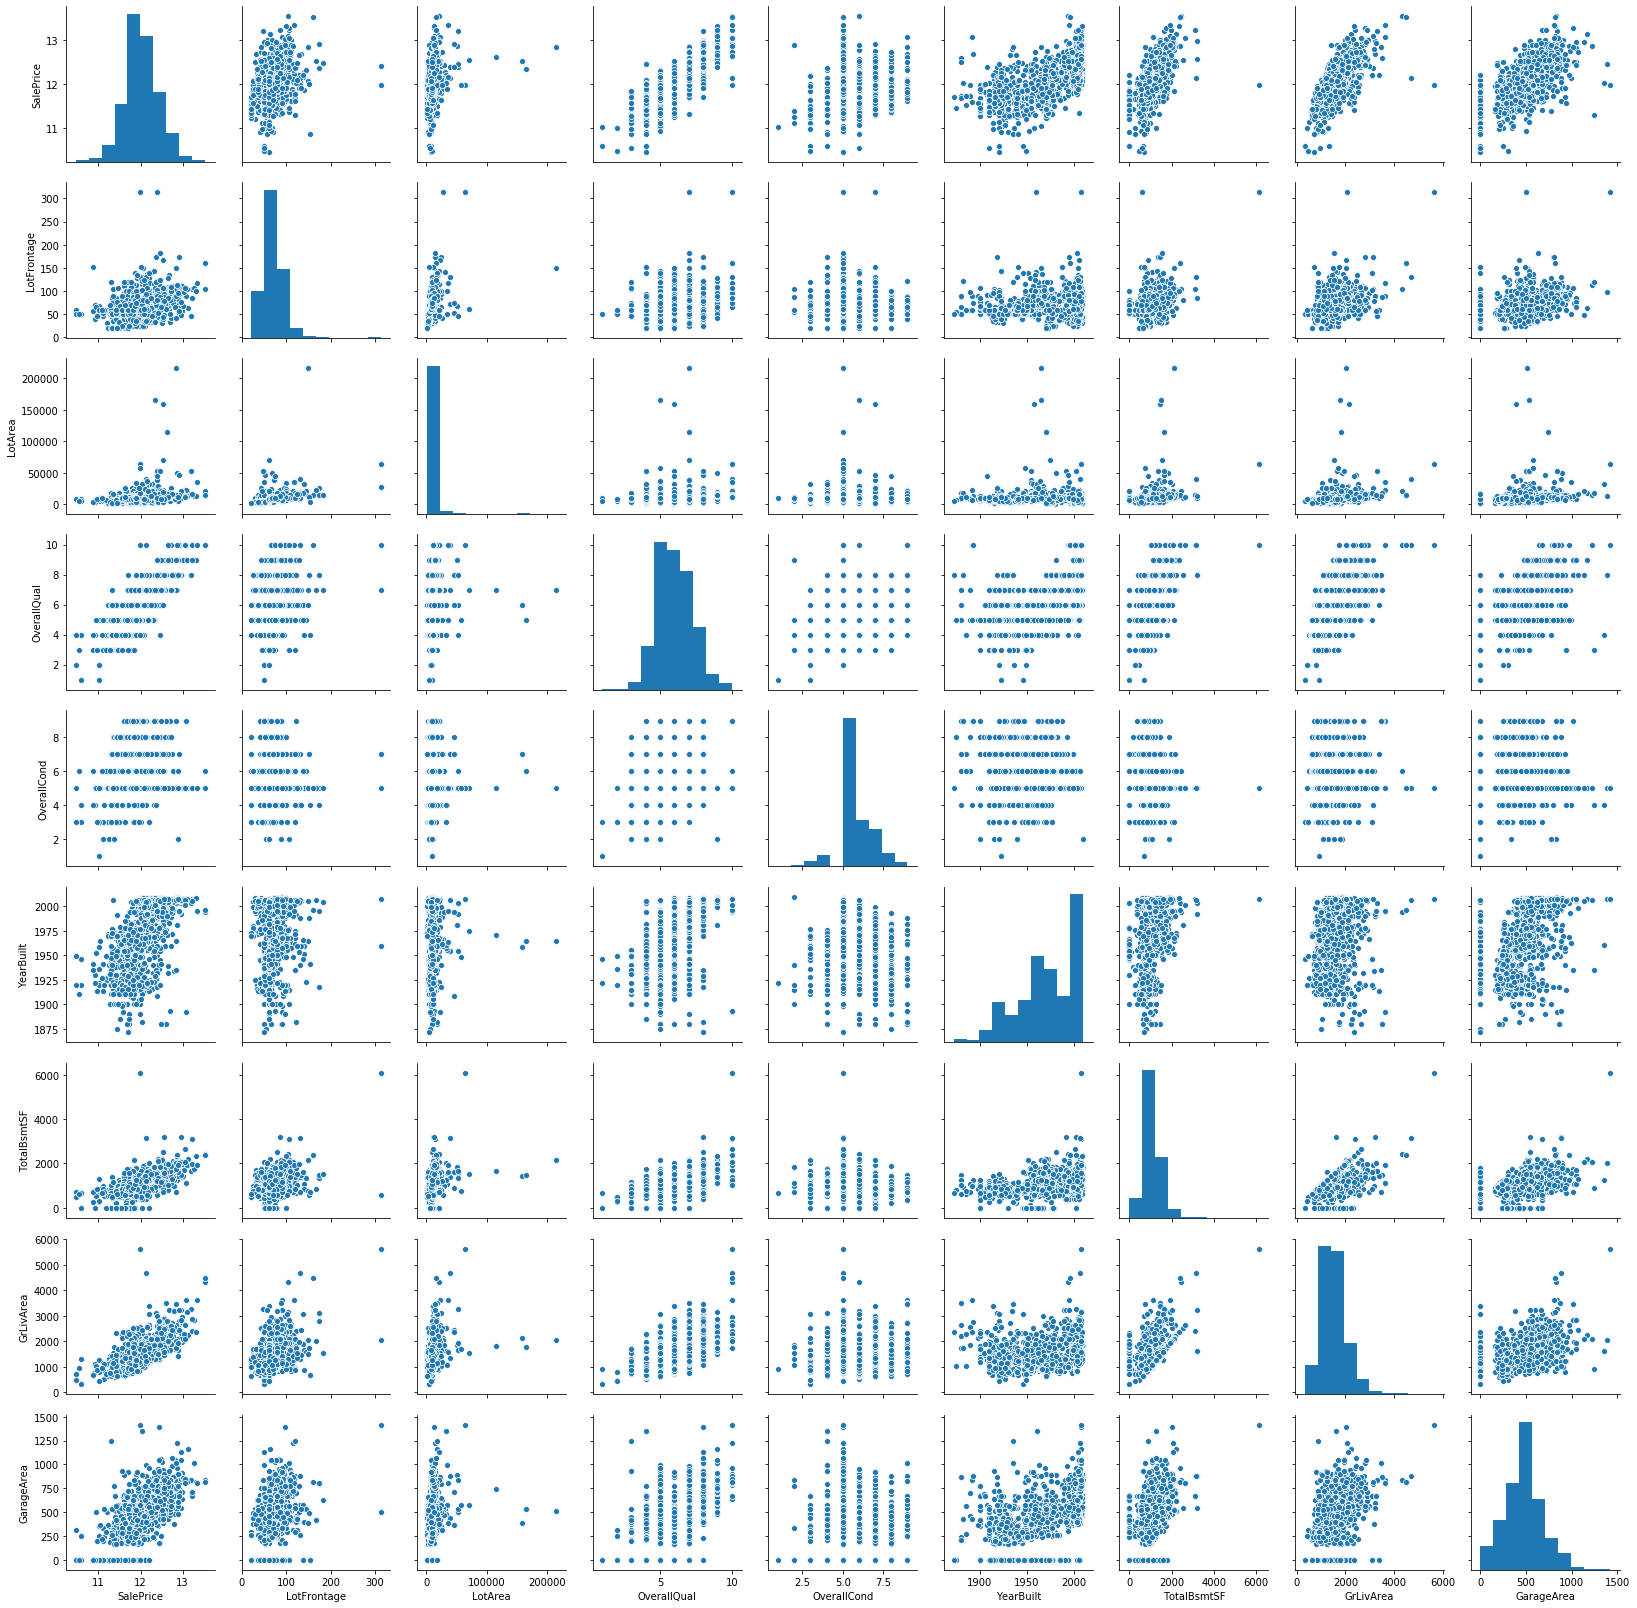

In [9]:
sns.pairplot(data_train[columns], size=2.5)
plt.show()

# Maniupulacja danymi

Już wiemy co nieco o naszych danych, znamy korelacje, rozkład zmiennej objaśnianej, jej zależności z zmiennymi objaśniającymi oraz podstawowe dane statystyczne. Pora więc przystąpić do obróbki danych, po to by zwiększyć wydajnoscnaszego modelu regresyjnego.

## Usuwanie danych odstających 

In [10]:
data_train.TotalBsmtSF = data_train.TotalBsmtSF[data_train.TotalBsmtSF < 4000]
data_train.LotFrontage = data_train.LotFrontage[data_train.TotalBsmtSF < 250]
data_train.GrLivArea = data_train.GrLivArea[data_train.GrLivArea < 4000] 

## Łączenie danych

In [11]:
y = data_train.SalePrice
data_train.drop(["SalePrice"], axis=1, inplace=True)
all_data = pd.concat([data_train, data_test])
all_data.shape

(2919, 79)

## Obróbka danych zakrzywionych

In [12]:
numerical = all_data.dtypes[all_data.dtypes != "object"].index
skewed_data = all_data[numerical].apply(lambda x: skew(x))
skewed_index = skewed_data[abs(skewed_data) >0.75].index

In [13]:
for i in numerical:
    all_data[i] = boxcox1p(all_data[i], 0.87)

## Usuwanie danych korelujących 

In [14]:
all_data.drop(["GarageCars", "GarageArea", "GarageYrBlt"], axis=1, inplace=True)

## Brakujace dane

In [15]:
all_data.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
LotFrontage     1654
FireplaceQu     1420
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
GrLivArea          4
MSZoning           4
BsmtFullBath       2
dtype: int64

In [16]:
all_data = all_data.drop(["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"], axis=1)

In [17]:
mean_keys = ["LotFrontage"]
im_mean = Imputer(missing_values="NaN",strategy='mean', axis=0)
im_mean.fit(all_data[mean_keys])
all_data[mean_keys] = im_mean.transform(all_data[mean_keys])

c:\users\michal\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [18]:
median_keys = ["GarageType", "GarageFinish", "GarageQual", "GarageCond", "BsmtFinType2", "BsmtExposure", "BsmtQual", "BsmtFinType1", "BsmtCond"]
for i in median_keys:
    all_data[i] = all_data[i].fillna(all_data[i].mode()[0])

In [19]:
all_data.fillna(0, inplace=True, axis=0)

In [20]:
all_data.isnull().sum().max()

0

## Obróbka danych kategoryzujacych 

In [21]:
category_data = all_data.select_dtypes(include='object')
all_data = pd.get_dummies(all_data)
all_data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,39.938830,44.606483,2997.259044,5.867858,4.314092,856.148478,856.148478,112.787990,345.169031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,15.099010,44.606483,3349.246070,5.098215,6.625062,846.090766,846.090766,0.000000,458.537011,0.0,...,0,0,0,1,0,0,0,0,1,0
2,39.938830,44.606483,3844.919172,5.867858,4.314092,855.404069,855.776285,95.474341,249.248625,0.0,...,0,0,0,1,0,0,0,0,1,0
3,45.740065,44.606483,3334.061023,5.867858,4.314092,823.301551,843.853302,0.000000,122.787499,0.0,...,0,0,0,1,1,0,0,0,0,0
4,39.938830,44.606483,4725.911827,6.625062,4.314092,855.031828,855.031828,187.171222,323.329943,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,94.442071,15.770112,831.157518,3.512708,5.867858,843.853302,843.853302,0.000000,0.000000,0.0,...,0,0,0,1,0,0,0,0,1,0
1455,94.442071,15.770112,815.434382,3.512708,4.314092,843.853302,843.853302,0.000000,140.493733,0.0,...,0,0,0,1,1,0,0,0,0,0
1456,15.099010,94.442071,6343.326225,4.314092,5.867858,840.122225,853.542624,0.000000,557.525455,0.0,...,0,0,0,1,1,0,0,0,0,0
1457,54.248615,41.108389,3603.164060,4.314092,4.314092,852.053031,852.053031,0.000000,181.088296,0.0,...,0,0,0,1,0,0,0,0,1,0


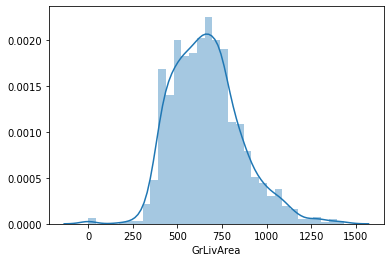

In [22]:
X = all_data[:1460]
test = all_data[1460:]
sns.distplot(X["GrLivArea"])

# Etap regresji

In [23]:
cvs = cross_val_score
lr = LinearRegression()
ls = Lasso()
print(cvs(lr, X, y, scoring="r2"))
print(cvs(ls, X, y, scoring="r2"))
lr.fit(X, y)
pred = lr.predict(test)
pred = np.expm1(pred)

c:\users\michal\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.90028627 0.86406368 0.88739799]
[0.75817096 0.72383419 0.71404956]


c:\users\michal\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [24]:
data = pd.DataFrame({"Id":idd, "SalePrice": pred})
data.to_csv("score1.csv", index=None)